In [65]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [66]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [67]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
  shuffle=True,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [68]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [69]:
len(dataset)

68

2025-05-11 11:15:44.330935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


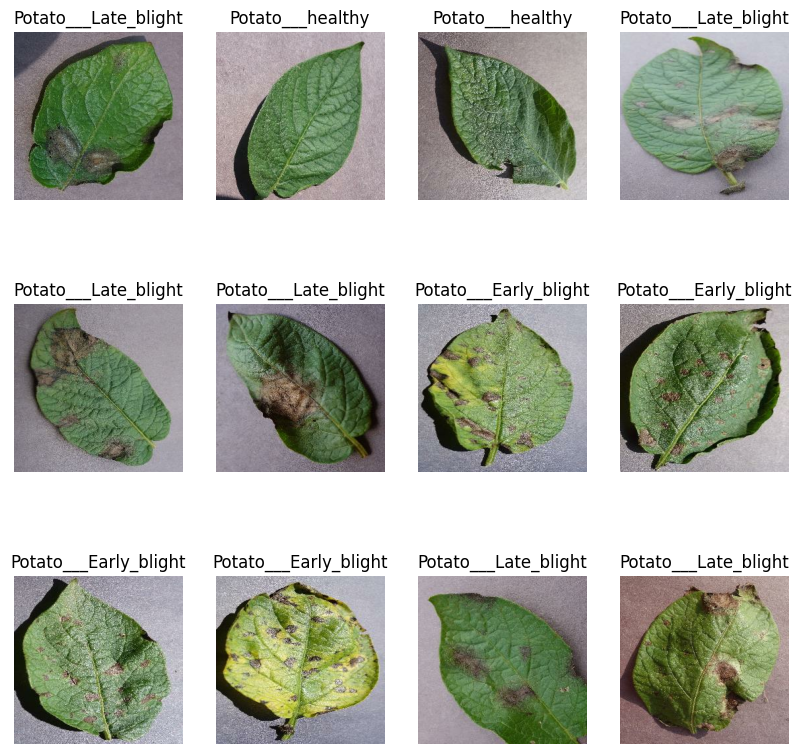

In [70]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
      plt.subplot(3, 4, i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[labels_batch[i]])
      plt.axis("off")


In [71]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [72]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [73]:
train_ds = dataset.take(54)
len(train_ds)

54

In [74]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [75]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [76]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [77]:
val_ds = test_ds.skip(6)
len(val_ds)

8

In [78]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffed=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffed:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    return train_ds, val_ds, test_ds

In [79]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [80]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [81]:
# caching & prefetching
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [82]:
# Scaling
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255)
])

In [83]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

## Build a CNN model

In [85]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(n_classes, activation='softmax')
  ])

model.build(input_shape=input_shape)

In [86]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [88]:
history = model.fit(
  train_ds,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  verbose=1,
  validation_data=val_ds,
)

Epoch 1/50


2025-05-11 11:19:10.382109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.4492 - loss: 0.9612 - val_accuracy: 0.5208 - val_loss: 0.8970
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5490 - loss: 0.8777 - val_accuracy: 0.7143 - val_loss: 0.6196
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.6964 - loss: 0.6886 - val_accuracy: 0.7969 - val_loss: 0.4719
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.8309 - loss: 0.4058 - val_accuracy: 0.8333 - val_loss: 0.4026
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.8583 - loss: 0.3725 - val_accuracy: 0.8490 - val_loss: 0.3760
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.8655 - loss: 0.3355 - val_accuracy: 0.7865 - val_loss: 0.4590
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.8852 - loss: 0.3069 - val_accuracy: 0.8073 - val_loss: 0.4361
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.8556 - loss: 0.3363 - val_accuracy: 0.8750 - val

In [89]:
socres = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9491 - loss: 0.1929


In [90]:
socres

[0.17401383817195892, 0.953125]

In [91]:
history

In [92]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [93]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

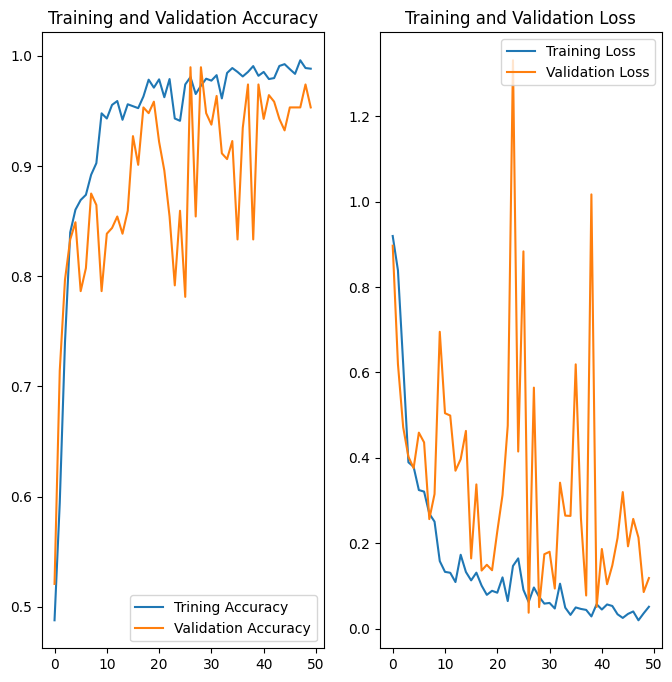

In [98]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Trining Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
First image's actual label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
predicted label: Potato___Late_blight


2025-05-11 12:43:38.682118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


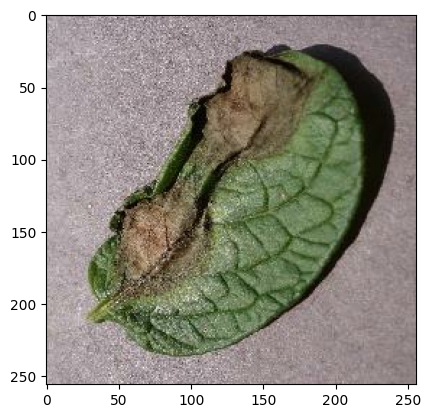

In [117]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])

    bacth_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(bacth_prediction[0])]) # the highest probability and find the class name

In [131]:
def predict(model, img):
  img_arry = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_arry = tf.expand_dims(img_arry, axis=0) # create a batch

  predictions = model.predict(img_arry)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = tf.nn.softmax(predictions[0])
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2025-05-11 12:57:08.342491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


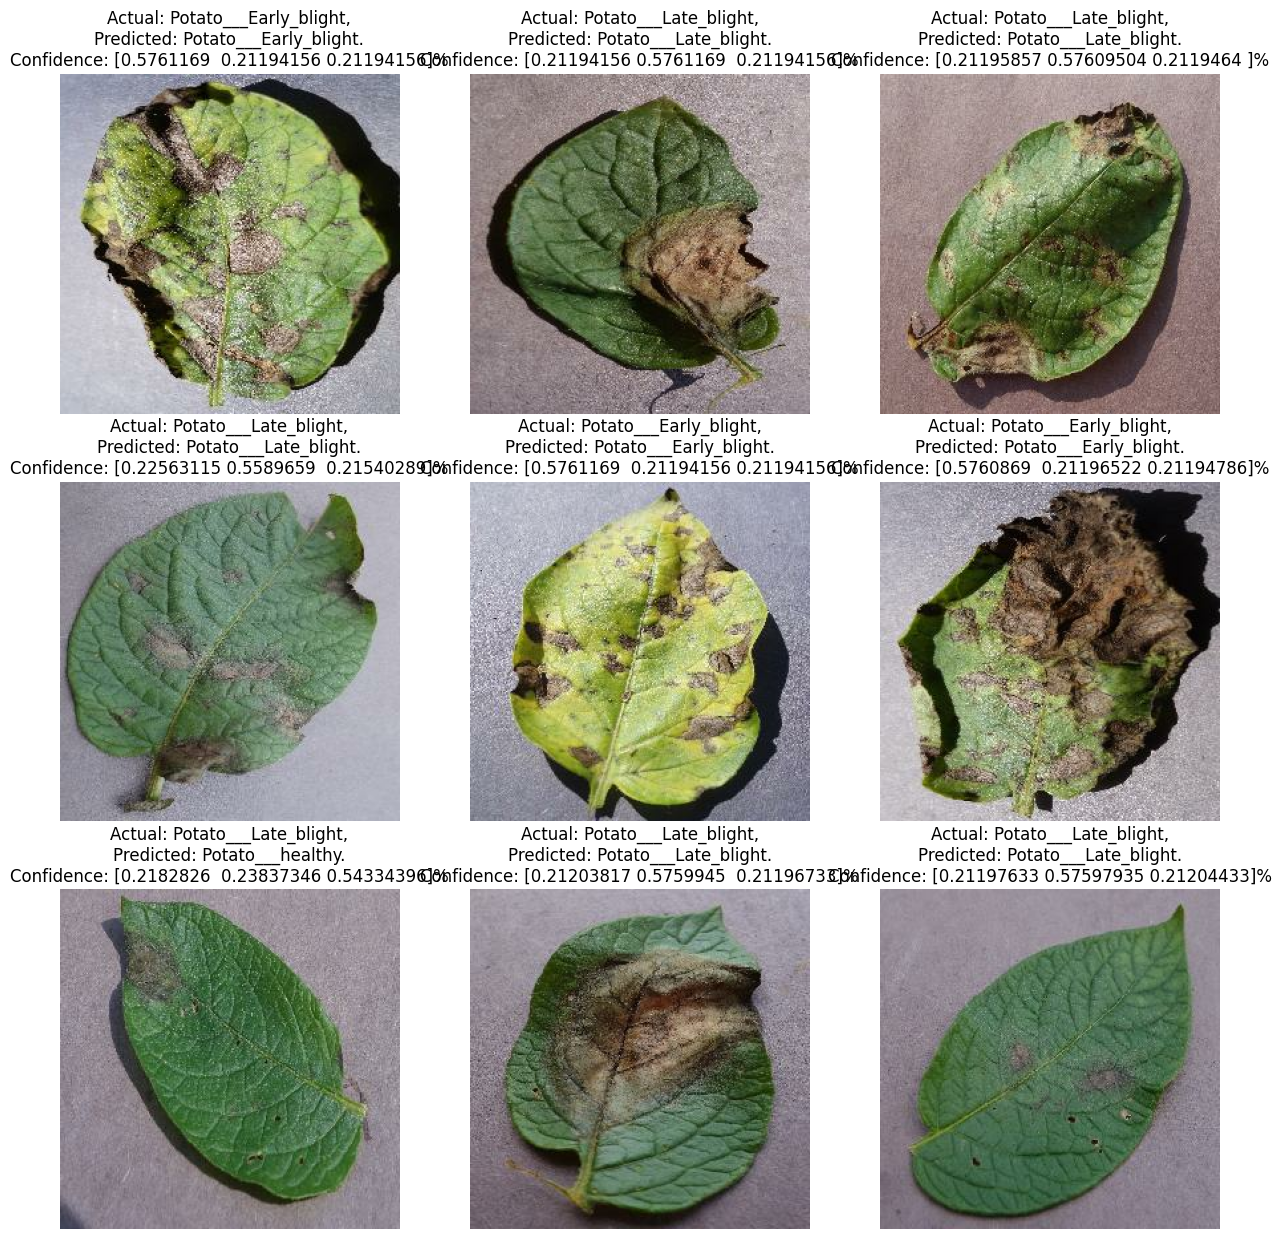

In [132]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")

        plt.axis("off")

In [133]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3/assets


INFO:tensorflow:Assets written to: ../models/3/assets


Saved artifact at '../models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  11223414240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186314880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186842160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186845856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186845328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186898896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186900480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186897312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186901712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186901360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11186901008: TensorSpec(shape=(), dtype=tf.resource, nam